In [83]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Labo avec MobileNetV2

In [84]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [85]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


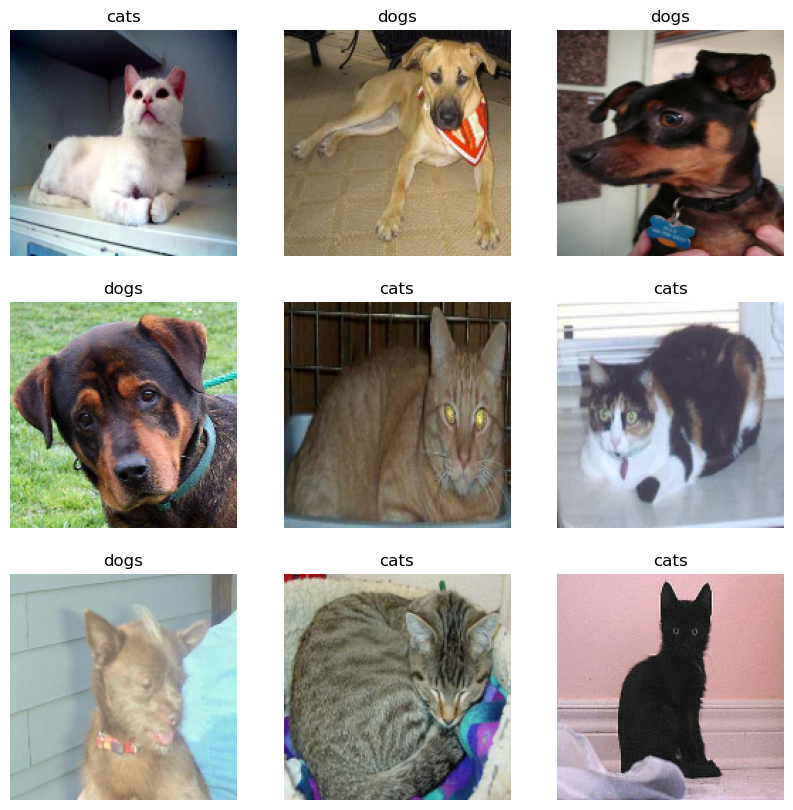

In [86]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [87]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [88]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [90]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

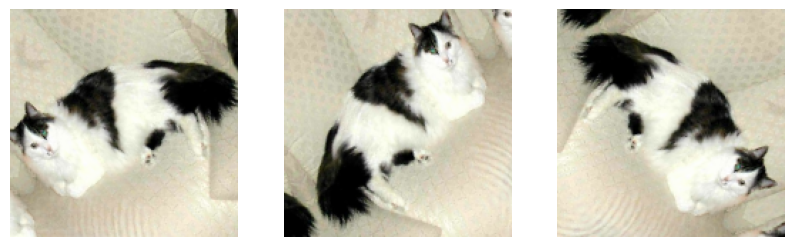

In [91]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [92]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [93]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [94]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [95]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [96]:
base_model.trainable = False

In [97]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [98]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [99]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [100]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [101]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [103]:
len(model.trainable_variables)

2

In [104]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 258ms/step - loss: 0.9885 - accuracy: 0.4010


In [105]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.99
initial accuracy: 0.40


In [106]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 28s 382ms/step - loss: 0.8963 - accuracy: 0.4800 - val_loss: 0.6711 - val_accuracy: 0.5953
Epoch 2/10
63/63 [==============================] - 24s 373ms/step - loss: 0.6383 - accuracy: 0.6345 - val_loss: 0.4854 - val_accuracy: 0.7228
Epoch 3/10
63/63 [==============================] - 23s 371ms/step - loss: 0.5018 - accuracy: 0.7265 - val_loss: 0.3923 - val_accuracy: 0.7686
Epoch 4/10
63/63 [==============================] - 23s 370ms/step - loss: 0.4195 - accuracy: 0.7910 - val_loss: 0.3129 - val_accuracy: 0.8243
Epoch 5/10
63/63 [==============================] - 23s 370ms/step - loss: 0.3680 - accuracy: 0.8235 - val_loss: 0.2731 - val_accuracy: 0.8564
Epoch 6/10
63/63 [==============================] - 24s 380ms/step - loss: 0.3111 - accuracy: 0.8575 - val_loss: 0.2391 - val_accuracy: 0.8787
Epoch 7/10
63/63 [==============================] - 24s 384ms/step - loss: 0.2905 - accuracy: 0.8645 - val_loss: 0.2134 - val_accuracy: 0.8936

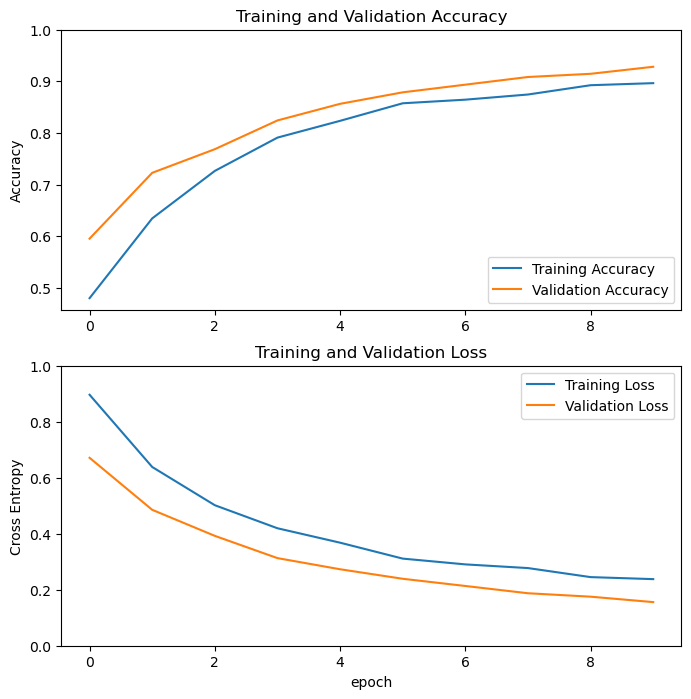

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [108]:
base_model.trainable = True

In [109]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [110]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [111]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [112]:
len(model.trainable_variables)

56

In [113]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 37s 510ms/step - loss: 0.1526 - accuracy: 0.9425 - val_loss: 0.0604 - val_accuracy: 0.9728
Epoch 11/20
63/63 [==============================] - 32s 512ms/step - loss: 0.1090 - accuracy: 0.9560 - val_loss: 0.0510 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 33s 524ms/step - loss: 0.1016 - accuracy: 0.9605 - val_loss: 0.0448 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 32s 515ms/step - loss: 0.1070 - accuracy: 0.9530 - val_loss: 0.0488 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 32s 501ms/step - loss: 0.0872 - accuracy: 0.9655 - val_loss: 0.0434 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 31s 499ms/step - loss: 0.0768 - accuracy: 0.9725 - val_loss: 0.0566 - val_accuracy: 0.9752
Epoch 16/20
63/63 [==============================] - 31s 497ms/step - loss: 0.0890 - accuracy: 0.9665 - val_loss: 0.0326 - val_accuracy:

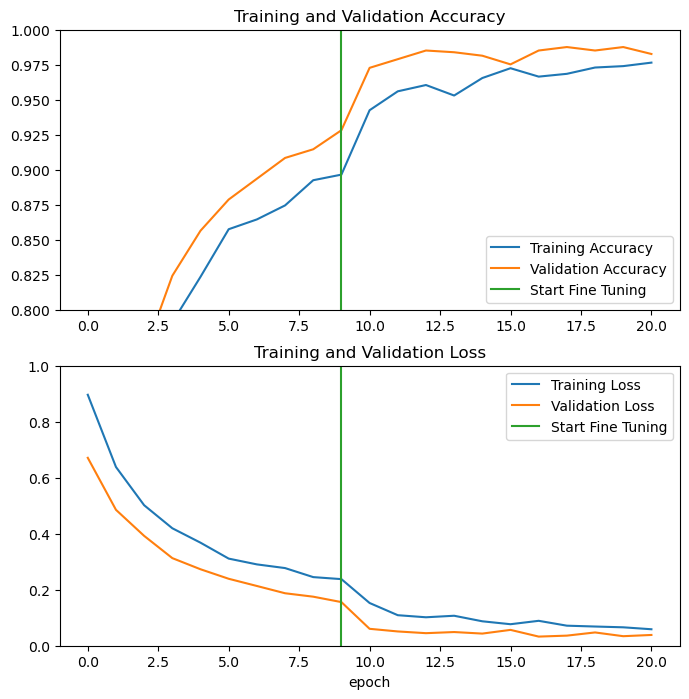

In [114]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [124]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 300ms/step - loss: 0.0743 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0]
Labels:
 [1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0]


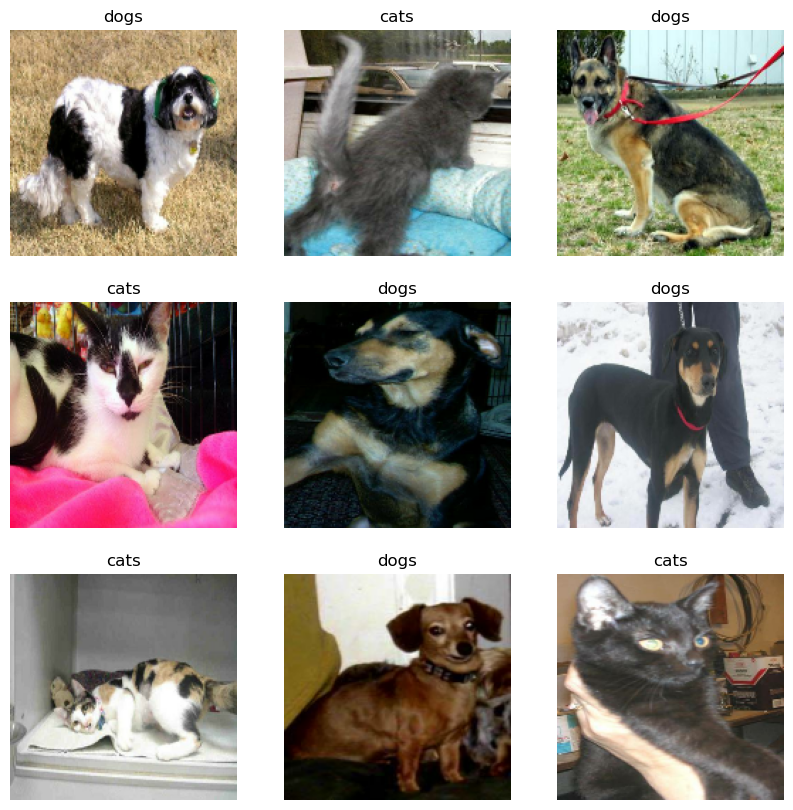

In [138]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [117]:
# https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr

In [118]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Test

In [119]:
MobileNetV2 = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')

MobileNetV2.trainable = False

In [120]:
# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [121]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [122]:
import cv2

img = cv2.imread('donut.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess(img)

img_prob = MobileNetV2.predict(img)


# plt.figure(figsize=(5,5))
# plt.title(list_class[label - 1 ])
# plt.imshow(resize.numpy().astype(int))
# plt.show()

1/1 [==============================] - 1s 661ms/step


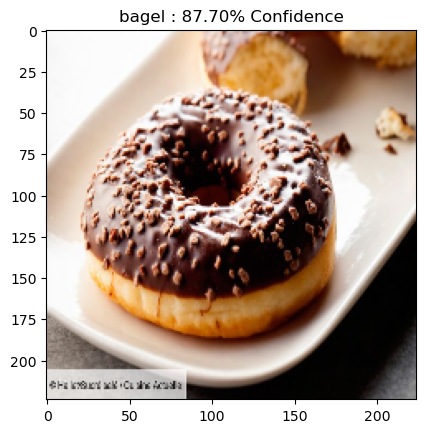

In [123]:
plt.figure()
plt.imshow(img[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(img_prob)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()